In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import gsd

In [2]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings
import math
import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    central_color = fresnel.color.linear([252 / 255, 41 / 255, 0 / 255])
    constituent_color = fresnel.color.linear([93 / 255, 210 / 255, 252 / 255])

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=[0, 0, 0],
                                                  roughness=0.5,
                                                  primitive_color_mix=1.0)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.color[snapshot.particles.typeid[:] == 0] = central_color
    geometry.radius[snapshot.particles.typeid[:] == 0] = 0.3
    geometry.color[snapshot.particles.typeid[:] == 1] = constituent_color
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
from flowermd.library import PPS, OPLS_AA_PPS
from flowermd.base import Pack, Simulation

/home/marjanalbooyeh/miniconda3/envs/ml-pps/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/marjanalbooyeh/miniconda3/envs/ml-pps/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')


In [4]:
pps = PPS(num_mols=2, lengths=1)
system = Pack(molecules=pps, density=0.2)

In [5]:
system.apply_forcefield(r_cut=2.5, force_field=OPLS_AA_PPS(), auto_scale=True, remove_charges=True, scale_charges=True, remove_hydrogens=True)

/home/marjanalbooyeh/miniconda3/envs/ml-pps/lib/python3.9/site-packages/gmso/core/topology.py:818: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_scales[index][scaling_interaction_idxes[interaction]] = value
/home/marjanalbooyeh/miniconda3/envs/ml-pps/lib/python3.9/site-packages/gmso/core/topology.py:818: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_scales[index][scaling_interaction_idxes[interaction]] = value


No charged group detected, skipping electrostatics.


In [6]:
snapshot = system.hoomd_snapshot

In [7]:
pps_aa_simulation = Simulation.from_system(system)

Initializing simulation state from a gsd.hoomd.Frame.


In [8]:
frame = pps_aa_simulation.state.get_snapshot()

In [10]:
pps_aa_simulation.reference_values

{'energy': unyt_quantity(1.7782, 'kJ/mol'),
 'length': unyt_quantity(0.36, 'nm'),
 'mass': unyt_quantity(32.06, 'amu')}

In [22]:
import pickle
with open("pps_ref_units.pkl", "wb") as f:
    pickle.dump(pps_aa_simulation.reference_values, f)

## error_units 

In [11]:
import unyt as u


In [17]:
pps_aa_simulation.reference_length.to("angstrom")

unyt_quantity(3.6, 'Å')

In [23]:
energy_kcal_mol = pps_aa_simulation.reference_energy.to("kcal/mol")
length_ang = pps_aa_simulation.reference_length.to("angstrom")
print(energy_kcal_mol/length_ang)

0.11805555555555557 kcal/(mol*Å)


In [19]:
(8 * energy_kcal_mol )/length_ang

unyt_quantity(0.94444444, 'kcal/(mol*Å)')

## Create rigid body initial frame

In [78]:
masses = frame.particles.mass
positions = frame.particles.position
N = frame.particles.N
box = frame.configuration.box
types = frame.particles.types
typeid = frame.particles.typeid

In [79]:
# indices of constituent particles
constituent_indx = [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13]]

In [80]:

com_mass = []
com_positions = []

for indx in constituent_indx:
    total_mass = np.sum(frame.particles.mass[indx])
    com_mass.append(total_mass)
    com_positions.append(
                np.sum(
                    frame.particles.position[indx]
                    * snapshot.particles.mass[indx, np.newaxis],
                    axis=0,
                )
                / total_mass
            )

In [81]:
rigid_frame = gsd.hoomd.Frame()
rigid_frame.particles.types = ['rigid']+types
rigid_frame.particles.N = 2
rigid_frame.particles.typeid = [0, 0]

rigid_frame.particles.position = com_positions
rigid_frame.particles.mass = com_mass
rigid_frame.configuration.box = box

In [82]:
## calculate moment of inertia (https://en.wikipedia.org/wiki/Moment_of_inertia#Definition_2)
# first, need to get the relative positions of constituent particles wrt com
rel_const_pos =  positions[constituent_indx[0]] - com_positions[0]
rel_const_pos

array([[ 0.08849504,  0.07669724,  0.64043651],
       [-0.02556489, -0.26707529,  0.49990807],
       [-0.07843468, -0.31309532,  0.11771188],
       [-0.01726601, -0.01489721, -0.12452878],
       [-0.08479617, -0.07348143, -0.61360397],
       [ 0.09703805,  0.32916023,  0.01655017],
       [ 0.14977624,  0.3746983 ,  0.39882241]])

In [83]:
const_mass = masses[constituent_indx[0]]

In [84]:
# using the code from hoomd blue rigid tutorial
I = np.zeros(shape=(3,3))
for (r, m) in zip(rel_const_pos, const_mass):
    I += m * (np.dot(r, r) * np.identity(3) - np.outer(r, r))
print('I_xx: ',  I[0, 0])
print('I_yy: ',  I[1, 1])
print('I_zz: ',  I[2, 2])

I_xx:  0.9103535961372244
I_yy:  0.7589334877928963
I_zz:  0.20423089114544785


In [85]:
# manually calculating moment of inertial diagonal
I_xx = 0
I_yy = 0
I_zz = 0
for i in constituent_indx[0]:
    m_k = masses[i]
    r = positions[i] - com_positions[0]
    I_xx += m_k * (r[1]**2 + r[2]**2)
    I_yy += m_k * (r[0]**2 + r[2]**2)
    I_zz += m_k * (r[0]**2 + r[1]**2)
print('I_xx: ',  I_xx)
print('I_yy: ',  I_yy)
print('I_zz: ',  I_zz)

I_xx:  0.9103535961372244
I_yy:  0.7589334877928963
I_zz:  0.2042308911454478


In [86]:
rigid_frame.particles.moment_inertia = [I_xx, I_yy, I_zz]*2
rigid_frame.particles.orientation = [(1, 0, 0, 0)] * 2

In [89]:
import gsd.hoomd
with gsd.hoomd.open(name='pps_only_rigid_centers.gsd', mode='x') as f:
    f.append(rigid_frame)

In [133]:
import hoomd
rigid = hoomd.md.constrain.Rigid()
rigid.body['rigid'] = {
    "constituent_types":list(np.asarray(types)[list(frame.particles.typeid)][constituent_indx[0]]),
    "positions": rel_const_pos,
    "orientations": [(1.0, 0.0, 0.0, 0.0)]* len(rel_const_pos),
}

In [91]:
list(np.asarray(types)[list(frame.particles.typeid)][constituent_indx[0]])

['ca', 'ca', 'ca', 'ca', 'sh', 'ca', 'ca']

In [134]:
# first placing the rigid centers
simulation = hoomd.Simulation(device=hoomd.device.GPU(), seed=4)
simulation.create_state_from_gsd(filename='pps_only_rigid_centers.gsd')
# render(simulation.state.get_snapshot())

In [135]:
# Now adding the constituent particles

rigid.create_bodies(simulation.state)


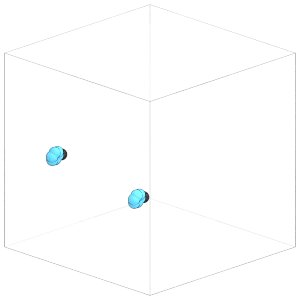

In [94]:
render(simulation.state.get_snapshot())

In [136]:
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
integrator.rigid = rigid
simulation.operations.integrator = integrator
simulation.run(0)
# render(simulation.state.get_snapshot())

In [96]:
hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='pps_rigid_lattice.gsd')

## Define the forces

In [254]:

rigid_simulation = hoomd.Simulation(device=hoomd.device.GPU(), seed=1)
rigid_simulation.create_state_from_gsd(filename='pps_rigid_lattice.gsd')

In [255]:
rigid = hoomd.md.constrain.Rigid()
rigid.body['rigid'] = {
    "constituent_types":list(np.asarray(types)[list(frame.particles.typeid)][constituent_indx[0]]),
    "positions": rel_const_pos,
    "orientations": [(1.0, 0.0, 0.0, 0.0)]* len(rel_const_pos),
}

In [256]:
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
rigid_simulation.operations.integrator = integrator
integrator.rigid = rigid
kT = 1.5
rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
nvt = hoomd.md.methods.ConstantVolume(
    filter=rigid_centers_and_free,
    thermostat=hoomd.md.methods.thermostats.Bussi(kT=kT))
integrator.methods.append(nvt)

In [257]:
cell = hoomd.md.nlist.Cell(buffer=0, exclusions=['body'])

In [258]:
rigid_simulation.state.get_snapshot().particles.types

['rigid', 'ca', 'sh']

In [259]:
pps_aa_simulation.forces[1]

In [260]:
lj = hoomd.md.pair.LJ(nlist=cell)

# use aa pps simulation to define lj and special lj forces between constituent particles
for k, v in dict(pps_aa_simulation.forces[0].params).items():
    lj.params[k] = v
    lj.r_cut[k] = 2.5

lj.params[('rigid', ['rigid', 'ca', 'sh'])]= dict(epsilon=0, sigma=0)
lj.r_cut[('rigid', ['rigid', 'ca', 'sh'])] = 0

In [261]:
integrator.forces.append(lj)
# integrator.forces.append(special_lj)

In [262]:
rigid_simulation.state.thermalize_particle_momenta(filter=rigid_centers_and_free,
                                             kT=kT)

rigid_simulation.run(0)

In [263]:
log_quantities = [
                    "kinetic_temperature",
                    "potential_energy",
                    "kinetic_energy",
                    "volume",
                    "pressure",
                    "pressure_tensor",
                ]
logger = hoomd.logging.Logger(categories=["scalar", "string", "particle"])
logger.add(rigid_simulation, quantities=["timestep", "tps"])
thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
rigid_simulation.operations.computes.append(thermo_props)
logger.add(thermo_props, quantities=log_quantities)

for f in integrator.forces:

    logger.add(f, quantities=["energy", "forces", "energies"])

gsd_writer = hoomd.write.GSD(
    filename="pps_trajectory.gsd",
    trigger=hoomd.trigger.Periodic(int(1)),
    mode="wb",
    logger=logger,
    filter=hoomd.filter.All(),
    dynamic=["momentum", "property"]
    )

rigid_simulation.operations.writers.append(gsd_writer)

In [264]:
rigid_simulation.run(3000)

In [265]:
rigid_simulation.operations.writers[0].flush()

In [266]:
hoomd.write.GSD.write(state=rigid_simulation.state, mode='xb', filename='pps_rigid_initial_run.gsd')

In [268]:
import pickle
f = open('pps_rigid_ff.pickle', "wb")
pickle.dump(integrator.forces, f)

In [269]:
rigid_simulation.run(10000)

In [270]:
rigid_simulation.operations.writers[0].flush()